In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyprind

# How many different values are in each column?

In [2]:
df = pd.read_csv('build/MGT_Cards.csv', parse_dates=True, index_col='Date')
print('Shape: {}\n'.format(df.shape))

for i in df.columns:
    print('Unique values in {}: {}'.format(i, len(df[i].unique())))

df.head()

Shape: (4156, 6)

Unique values in Price: 794
Unique values in Link: 150
Unique values in Name: 148
Unique values in Edition: 23
Unique values in Rarity: 5
Unique values in Available: 145


,Price,Link,Name,Edition,Rarity,Available
Date,,,,,,
2018-04-04,0.08,/de/Magic/Products/Singles/Dominaria/Entrei%C3...,Entrei%C3%9Fen,Dominaria,Common,3438
2018-04-05,0.06,/de/Magic/Products/Singles/Dominaria/Entrei%C3...,Entrei%C3%9Fen,Dominaria,Common,3438
2018-04-06,0.09,/de/Magic/Products/Singles/Dominaria/Entrei%C3...,Entrei%C3%9Fen,Dominaria,Common,3438
2018-04-07,0.06,/de/Magic/Products/Singles/Dominaria/Entrei%C3...,Entrei%C3%9Fen,Dominaria,Common,3438
2018-04-08,0.06,/de/Magic/Products/Singles/Dominaria/Entrei%C3...,Entrei%C3%9Fen,Dominaria,Common,3438


# Which Editions are most popular?

In [3]:
df_temp_1 = df.groupby(['Link']).agg({'Edition':'max', 'Name': 'max'}).groupby('Edition').count().sort_values(by='Name', ascending=False)
df_temp_2 = df.groupby('Edition').agg({'Price':'mean'}).sort_values(by='Price', ascending=False)

df_edition = df_temp_1.join(df_temp_2, how='outer').sort_values(by='Name', ascending=False)

In [4]:
df_edition.head(10)

,Name,Price
Edition,,
Dominaria,74,2.270765
Masters+25,19,1.072912
Rivals+of+Ixalan,9,1.378111
Ixalan,8,1.307875
Kaladesh,7,2.094762
Hour+of+Devastation,5,1.192533
Unstable,5,1.699000
Aether+Revolt,4,4.903417
Khans+of+Tarkir,3,13.404222


# Which are the priciest Editions/Rarities?
To minimize outliers, only Editions/Rarities with more than n entries are compared.

In [5]:
n = 10

df_price = df.groupby('Link').agg({'Price':'mean', 'Edition':'max', 'Rarity':'max', 'Available':'mean'}).reset_index().groupby(['Edition', 'Rarity']).agg({'Price':'mean', 'Available':'sum', 'Link':'count'})

In [6]:
df_price[df_price['Link']>=n].sort_values('Price', ascending=False).head(20)

Price  Available  Link
Edition    Rarity                             
Dominaria  Rare      1.533913      46136    42
           Uncommon  0.509876      36425    18
Masters+25 Common    0.378333      37776    10

# How worthy is a 15 cards booster-pack from different Editions?
Only Editions/Rarities with more than n entries have been included.

In [7]:
n = 10

df_booster = df_price[df_price['Link']>=n].reset_index()
data = []
for edition in df_booster[df_booster['Link']>=n].reset_index()['Edition'].unique():
    df_edition = df_booster[df_booster['Edition']==edition]
    rarities = df_edition['Rarity'].unique()
    common = df_edition[df_edition['Rarity']=='Common']['Price'].values[0] if 'Common' in rarities else 0
    uncommon = df_edition[df_edition['Rarity']=='Uncommon']['Price'].values[0] if 'Uncommon' in rarities else common
    rare = df_edition[df_edition['Rarity']=='Rare']['Price'].values[0] if 'Rare' in rarities else uncommon
    mythic = df_edition[df_edition['Rarity']=='Mythic']['Price'].values[0] if 'Mythic' in rarities else rare
    
    booster_price = 10*common + 3*uncommon + 7/8*rare + 1/8*mythic
    data.append([edition, booster_price])

df_booster = pd.DataFrame(data, columns=['Edition', 'Booster'])

In [8]:
df_booster[df_booster['Booster']>=3].sort_values('Booster', ascending=False).head(20)

,Edition,Booster
1,Masters+25,5.296667
0,Dominaria,3.063540


# Which are the priciest cards?

In [9]:
n = 10

df.groupby('Link').agg({'Edition':'max', 'Name':'max', 'Price':'mean'}).sort_values('Price', ascending=False).reset_index(drop=True).head(n)

,Edition,Name,Price
0,Dominaria,Karn%2C+Urzas+Spross,27.332333
1,Dominaria,Bernsteinmox,18.074000
2,Khans+of+Tarkir,Blutbeflecktes+Schlammloch,15.144667
3,Khans+of+Tarkir,Bewaldete+Gebirgsausl%C3%A4ufer,14.850667
4,Dominaria,Teferi%2C+Held+Dominarias,10.856667
5,Khans+of+Tarkir,Zerzauste+Heide,10.217333
6,Aether+Revolt,Schreitende+Balliste,9.754333
7,Dominaria,Lyra+Morgenbringer,9.047600
8,Dominaria,Geschichte+Benalias,7.434333
9,Stronghold,Traumhallen,7.260000


# Which cards had the larges price range?

In [10]:
df.head(2)

,Price,Link,Name,Edition,Rarity,Available
Date,,,,,,
2018-04-04,0.08,/de/Magic/Products/Singles/Dominaria/Entrei%C3...,Entrei%C3%9Fen,Dominaria,Common,3438
2018-04-05,0.06,/de/Magic/Products/Singles/Dominaria/Entrei%C3...,Entrei%C3%9Fen,Dominaria,Common,3438


In [11]:
n = 5

df_range = df.groupby('Link').agg({'Price':['idxmin', 'idxmax', 'min', 'max']})
df_range['Range'] = df_range['Price']['max'] - df_range['Price']['min']
df_range['Days'] = df_range['Price']['idxmax'] - df_range['Price']['idxmin']
df_range['Sign'] = (df_range['Price']['idxmax'] > df_range['Price']['idxmin']).apply(lambda x: 1 if x else -1)
df_range['Percentage'] = df_range['Range'] / df_range['Price']['min'] * 100 * df_range['Sign']

In [12]:
df_range.replace([np.inf, -np.inf], np.nan).sort_values('Percentage', ascending=False).head(n)

Price             \
                                                       idxmin     idxmax   
Link                                                                       
/de/Magic/Products/Singles/Mirrodin/Stromleiter    2018-03-29 2018-04-15   
/de/Magic/Products/Singles/Amonkhet/Kampf-Zeleb... 2018-03-30 2018-04-10   
/de/Magic/Products/Singles/Commander+2013/Nacht... 2018-04-01 2018-04-24   
/de/Magic/Products/Singles/Stronghold/Traumhallen  2018-03-28 2018-04-17   
/de/Magic/Products/Singles/Masters+25/Unbarmher... 2018-04-08 2018-04-18   

                                                                 Range  \
                                                     min    max          
Link                                                                     
/de/Magic/Products/Singles/Mirrodin/Stromleiter     0.02   0.64   0.62   
/de/Magic/Products/Singles/Amonkhet/Kampf-Zeleb...  0.40   4.08   3.68   
/de/Magic/Products/Singles/Commander+2013/Nacht...  0.10   0.76   0.66   
/de/Magic/Products/Singles/Stronghold/Traumhallen   2.50  15.02  12.52   
/de/Magic/Products/Singles/Masters+25/Unbarmher...  0.17   0.89   0.72   

                                                      Days Sign   Percentage  
                                                                              
Link                                                                          
/de/Magic/Products/Singles/Mirrodin/Stromleiter    17 days    1  3100.000000  
/de/Magic/Products/Singles/Amonkhet/Kampf-Zeleb... 11 days    1   920.000000  
/de/Magic/Products/Singles/Commander+2013/Nacht... 23 days    1   660.000000  
/de/Magic/Products/Singles/Stronghold/Traumhallen  20 days    1   500.800000  
/de/Magic/Products/Singles/Masters+25/Unbarmher... 10 days    1   423.529412

In [13]:
df_range.replace([np.inf, -np.inf], np.nan).sort_values('Percentage', ascending=True).head(n)

Price             \
                                                       idxmin     idxmax   
Link                                                                       
/de/Magic/Products/Singles/Fate+Reforged/Temur-... 2018-04-15 2018-04-13   
/de/Magic/Products/Singles/Dominaria/Jodah%2C+e... 2018-04-24 2018-03-28   
/de/Magic/Products/Singles/Dominaria/Baird%2C+V... 2018-04-13 2018-04-04   
/de/Magic/Products/Singles/Dominaria/Aryel%2C+R... 2018-04-21 2018-03-29   
/de/Magic/Products/Singles/Dominaria/Jayas+bren... 2018-04-17 2018-04-02   

                                                               Range     Days  \
                                                     min   max                  
Link                                                                            
/de/Magic/Products/Singles/Fate+Reforged/Temur-...  0.02  0.59  0.57  -2 days   
/de/Magic/Products/Singles/Dominaria/Jodah%2C+e...  0.26  3.40  3.14 -27 days   
/de/Magic/Products/Singles/Dominaria/Baird%2C+V...  0.08  0.98  0.90  -9 days   
/de/Magic/Products/Singles/Dominaria/Aryel%2C+R...  0.47  4.85  4.38 -23 days   
/de/Magic/Products/Singles/Dominaria/Jayas+bren...  0.19  1.94  1.75 -15 days   

                                                   Sign   Percentage  
                                                                      
Link                                                                  
/de/Magic/Products/Singles/Fate+Reforged/Temur-...   -1 -2850.000000  
/de/Magic/Products/Singles/Dominaria/Jodah%2C+e...   -1 -1207.692308  
/de/Magic/Products/Singles/Dominaria/Baird%2C+V...   -1 -1125.000000  
/de/Magic/Products/Singles/Dominaria/Aryel%2C+R...   -1  -931.914894  
/de/Magic/Products/Singles/Dominaria/Jayas+bren...   -1  -921.052632

In [14]:
unique_cards = df['Link'].unique()

In [15]:
from multiprocessing import Pool, Manager

manager = Manager()
data_price = manager.list()

def cardGenerator():
    for card in df['Link'].unique():
        yield card

def fitPrice(card, data_price=data_price):
    df_price = df[df['Link']==card].reset_index()[['Price', 'Date']]
    df_price['Range'] = (df_price.reset_index().Date - df_price.Date.min()).astype('timedelta64[D]')
    coefP = np.polyfit(df_price.Range, df_price.Price, 1)
    data_price.append([card, coefP[0], coefP[1], df_price.Date.min()])
        
pool = Pool()
_ = pool.map(fitPrice, cardGenerator())

In [16]:
df_price = pd.DataFrame(list(data_price), columns=['Link', 'm/Day', 'b', 'b-Date'])
df = df.reset_index().merge(df_price, on='Link', how='outer').set_index('Date')

# Which cards changed their value the most?

In [18]:
n = 10

df_trend = df.groupby('Link').agg({'Rarity':'max', 'Available':'mean', 'm/Day':'max', 'b':'max', 'b-Date':'max'}).reset_index()
df_trend.sort_values('m/Day', ascending=False).head(n)

,Link,Rarity,Available,m/Day,b,b-Date
143,/de/Magic/Products/Singles/Stronghold/Traumhallen,Rare,457,0.328906,1.909795,2018-03-24
14,/de/Magic/Products/Singles/Dominaria/Bernsteinmox,Mythic,715,0.145562,15.963355,2018-03-26
29,/de/Magic/Products/Singles/Dominaria/Geschicht...,Mythic,392,0.144314,5.341785,2018-03-26
4,/de/Magic/Products/Singles/Amonkhet/Kampf-Zele...,Mythic,707,0.105459,0.571505,2018-03-26
1,/de/Magic/Products/Singles/Aether+Revolt/Schre...,Rare,989,0.089773,8.452624,2018-03-26
48,/de/Magic/Products/Singles/Dominaria/Naru+Meha...,Mythic,573,0.047120,2.233567,2018-04-01
30,/de/Magic/Products/Singles/Dominaria/Goblin-Ke...,Rare,661,0.045158,0.357879,2018-03-22
60,/de/Magic/Products/Singles/Dominaria/Schwefelf...,Rare,921,0.042848,2.730043,2018-03-26
107,/de/Magic/Products/Singles/Khans+of+Tarkir/Bew...,Rare,1766,0.038096,14.298280,2018-03-26
0,/de/Magic/Products/Singles/Aether+Revolt/Baral...,Rare,1180,0.024583,3.106215,2018-03-26


In [19]:
df_trend.sort_values('m/Day', ascending=True).head(n)

,Link,Rarity,Available,m/Day,b,b-Date
39,/de/Magic/Products/Singles/Dominaria/Karn%2C+U...,Mythic,401,-0.216317,31.867774,2018-03-18
16,/de/Magic/Products/Singles/Dominaria/D%C3%A4mp...,Uncommon,1641,-0.165051,6.595450,2018-03-25
50,/de/Magic/Products/Singles/Dominaria/Oberste+K...,Rare,1091,-0.123768,3.234828,2018-03-27
36,/de/Magic/Products/Singles/Dominaria/Jodah%2C+...,Rare,1238,-0.117994,2.840834,2018-03-28
142,/de/Magic/Products/Singles/Store+Championship+...,Rare,379,-0.112152,6.126805,2018-03-28
10,/de/Magic/Products/Singles/Dominaria/Aryel%2C+...,Rare,1137,-0.110099,4.230858,2018-03-17
44,/de/Magic/Products/Singles/Dominaria/Marwyn+di...,Rare,1293,-0.107359,3.624769,2018-03-23
72,/de/Magic/Products/Singles/Dominaria/Traxos%2C...,Rare,1206,-0.100495,2.994505,2018-04-12
40,/de/Magic/Products/Singles/Dominaria/Karns+tem...,Rare,1281,-0.084689,2.210582,2018-03-30
18,/de/Magic/Products/Singles/Dominaria/Der+Artef...,Rare,682,-0.079137,2.603276,2018-03-25


# Are the prices falling or raising?

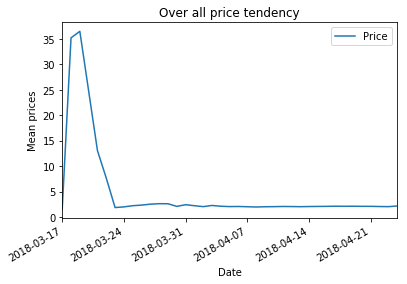

In [20]:
df.reset_index().groupby('Date').agg({'Price':'mean'}).plot()
plt.title('Over all price tendency')
plt.ylabel('Mean prices')
plt.show()